# Machine Learning in Finance

Mergers and acquisitions (M&A) refer to the consolidation of companies, a company may purchase and absorb another company, merge with it to create a new company or stage a hostile takeover. Abnormal returns are defined as unusually high profits or losses that are generated in a portfolio or investment. In cases of abnormal returns the performance of investment or portfolio diverges from expected rate of return. Cumulative abnormal return is sum of all abnormal returns in a given time period. 
The focus of this report is the presence of abnormal returns in Merger and acquisition (M&A) transactions. Data from various M&A transactions will be used to construct a linear regression model, with whose help the cumulative abnormal returns, caused by a M&A transaction, can be computed and then used as a dependent variable in a multiple regression model to investigate the effect of the chosen variables on the cumulative abnormal returns.

## Imports

In [1]:
import pandas as pd
import numpy as np
import csv
import re
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
import matplotlib.pyplot as plt
import scipy.stats as stats

## Project Classes

### Cleaning Class

In [2]:
class DataCleaner():
    """
    Class to house all of our cleaning functions
    """
    def clean_merger_data(self,df_merger, df_text):
        """
        Function that takes the raw data imported from the csv and transforms it into the wanted data set for analysis
        """
        #forward fills all the missing data for ["deal_number","deal_headline","deal_status"] that refinitive wrongly put into the row before
        df_merger[["deal_number","deal_headline","deal_status"]] = df_merger[["deal_number","deal_headline","deal_status"]].fillna(method = "ffill")

        #drops all data points where the accquirer or target is not a publicly traded company because we can't query price information for those
        df=df_merger.dropna(subset=["acc_isin","targ_isin"])

        #create a data frame for the wanted deals
        us_full_acc = df_merger.query("deal_status == 'Completed' and acc_isin.str.contains('US') and targ_isin.str.contains('US') and deal_type.str.contains('Acquisition 100%')",
                                       engine = 'python')
        #filter out deals with no given value as deal_value will be a variable in the prediction model
        us_full_acc = us_full_acc.query("deal_value != 'n.a.'")

        #merge the data set with the wanted deals with the data set cointaing the text for the deals into a data set containing wanted deals and their text
        df_merged = pd.merge(us_full_acc,mergers_text_df,how = "inner", on = "deal_number")

        #construct a column for the variable annoucement date by extracting the announcement date from the deal text and tranforming it into a datetime variable
        df_merged["ann_date"] = df_merged["deal_comment"]
        df_merged["ann_date"] = df_merged["ann_date"].str.replace(r'/',"", regex= True)
        df_merged["ann_date"] = df_merged["ann_date"].str.replace(r'\D+',"", regex = True)
        df_merged["ann_date"] = df_merged["ann_date"].str[:6]
        #This data row has 0 instead of the letter O and this leads to an error when performing to_datetime() therefore it is droped from the data set
        df_merged = df_merged.drop(index = 163)
        df_merged["ann_date"] = pd.to_datetime(df_merged["ann_date"], format = "%d%m%y")

        #kepping only the relevant columns
        df_merged = df_merged[["deal_number","acc_isin","ann_date","deal_value","deal_comment"]]

        return df_merged
    
    def create_wanted_date_df(self, df, wanted_date):
        """
        Function to create a data frame with only the wanted dates and cleaned variables
        """
        # Some ISINS get all values queryed as Na from Refinitive and for others there is no price data for the time period when the deal takes place
        # Due to this we removed all of them
        isins_to_remove = ["US5893311077","US9021041085","US38259P5089","US3167901046","US26142R1041","US98421B1008","US90187B4086","US13123X1028","US4698141078",
                          "US32006W1062","US1080351067","US0357104092","US0357104092","US6757463095","US36870G1058","US41165F1012","US73688F1021","US88339B1026",
                          "US76090R1014","US7103111016","US2935941078","US35243J1016","US00951K1043","US29788T1034","US2256551092","US05875B1061","US1651677437",
                           "US2103131023","US8378411057","US8041371076","US8354384096","US0547548745"]
        
        #query the wanted date and remove problematic isins
        df_date = df.query("ann_date >= @wanted_date").copy()
        df_date = df_date.query("acc_isin not in @isins_to_remove").copy()

        #reset index to make it correct for the current data frame
        df_date.reset_index(inplace = True, drop = True)

        #for loop to clean the deal_value variable so it can be converted to integer and used as a varaible for the prediction
        for index,row in df_date.iterrows():
            deal_value = row["deal_value"]
            deal_value = deal_value.strip("*")
            if deal_value.__contains__("."):
                deal_value = deal_value[:-2]
                deal_value = deal_value.replace(".","").replace(",","")

            df_date.loc[index,"deal_value"] = int(deal_value)

        #create variable based on text
        
        df_date = df_date.assign(premium = 0)
        i_list = df_date.query("deal_comment.str.contains('premium')", engine = "python").index
        df_date.loc[i_list,"premium"] = 1
        
        #exctract evething between the words 'premium' and 'per', because between them is the % of the premium
        df_date["premium_perc"] = df_date["deal_comment"].str.findall("premium(.*?)per").copy()
        #iterate over the data frame to clean the premium_perc variable and only keep numbers
        for index, row in df_date.iterrows():
            try:
                #Index 135, 180 , 231 and 247 dont contain the number of the premium, number was computed by hand and inserted
                if index == 135:
                    string = 8.5 
                elif index == 180:
                    string = 17.4
                elif index == 231:
                    string = 56 
                elif index == 247:
                    string = 4.5669 
                #clean string to only keep numbers and convert to float
                else:
                    string = row["premium_perc"][0]
                    string = float(re.sub(r"[^0-9|.]","",string))
            #some deal comments don't contain a %, upon inspection of the comments, it was assumed that there was no premium paid
            except IndexError:
                string = np.nan
            df_date.loc[index,"premium_perc"] = string

        return df_date
    
    def clean_static_data(self, df, drop_columns):
        """
        Function to clean the data set with the static variables Company Name and Ticker Symbol
        """
        #drop companies for which refinitive can't find their name and drop unncessary columns that refinitive returns
        df = df.dropna(subset=["NAME"])
        df = df.drop(labels = drop_columns, axis = 1)

        #change variable names to enable the use of the pandas .query() function (doesn't work with spaces in variable names)
        df.rename(columns = {'acc ISIN':'acc_isin','NAME':'company_name', 'TICKER SYMBOL':"ticker"}, inplace = True)
        df = df[["acc_isin","company_name","ticker"]]

        # clean up and simplify company name - delisted companies contain DEAD - DELIST.date in their name, this is unncessary for our analysis
        df["company_name"] = df["company_name"].str.replace(r'(',"", regex= True)
        df["company_name"] = df["company_name"].str.replace(r')',"", regex= True)
        df["company_name"] = df["company_name"].str.replace('-',"")
        df["company_name"] = df["company_name"].str.replace('DEAD',"")
        df["company_name"] = df["company_name"].str.replace(r'DELIST.*',"", regex= True)

        #reset index to make it correct for the current data frame
        df.reset_index(inplace=True, drop = True)

        return df
    
    def clean_timeseries_data(self, df):
        """
        Function that cleans time series data from Refinitve
        """
        #transform from wide format to long format
        df=pd.melt(df, id_vars = 'Name' )

        #get list for indexes containg P#S values because there the company name is written 2 times => makes merging on company name imposible
        i_list = df.query("variable.str.contains('#S')", engine = "python").index

        #for loop to remove duplicate company names
        for i in i_list:
            strings = df.loc[i,"variable"]
            string = string = ' '.join(dict.fromkeys(strings.split()))
            df.loc[i,"variable"] = string

        #add column for variable type, rename to variable later, now can't be variable because that column already exists
        df['kennzahl'] = np.nan

        #save the P#S variable as PriceS, becase P#S interferres with the pandas .query() function
        df.loc[i_list,"kennzahl"] = 'PriceS'

        #fill variable type column for other variables
        i_list = df.query("variable.str.contains('- TOT RETURN IND')", engine = "python").index
        df.loc[i_list,"kennzahl"] = 'TOT RETURN IND'
        i_list = df.query("variable.str.contains('- CURRENT RATIO')", engine = "python").index
        df.loc[i_list,"kennzahl"] = 'CURRENT RATIO'
        i_list = df.query("variable.str.contains('- CASH')", engine = "python").index
        df.loc[i_list,"kennzahl"] = 'CASH'

        #remove variable names from the initial column, which will now hold only company names to make merging possible
        df["variable"] = df["variable"].str.replace(r' - TOT RETURN IND',"")
        df["variable"] = df["variable"].str.replace(r' - CURRENT RATIO',"")
        df["variable"] = df["variable"].str.replace(r' - CASH',"")
        df["variable"] = df["variable"].str.replace('(#S)',"", regex= False)
        df["variable"] = df["variable"].str.replace('-',"",)
        df["variable"] = df["variable"].str.rstrip()

        #rename and reorder columns to simplying using the data frame
        df.rename(columns = {'Name':'date','variable':'company_name',"kennzahl":"variable"}, inplace = True)
        #keep only relevant columns
        df = df[["date","company_name","variable","value"]] 
        #drop entries where Refinitive returns as error
        to_drop = df.query("company_name.str.contains('#ERROR')", engine = "python").index
        df = df.drop(index = to_drop)

        #cleanup company name variable to make merging on company name possible
        df["company_name"] = df["company_name"].str.replace(r'(',"", regex= True)
        df["company_name"] = df["company_name"].str.replace(r')',"", regex= True)
        df["company_name"] = df["company_name"].str.replace('DEAD',"")
        df["company_name"] = df["company_name"].str.replace(r'DELIST.*',"", regex= True)

        #make date a datetime variable
        df["date"] = pd.to_datetime(df["date"], dayfirst=True)

        #reset index to make it correct for the current data frame
        df.reset_index(inplace=True, drop = True)

        # correct JOHNSON & JOHNSON company_name after cleaning, it gets changed to 'JOHNSON &' during the deduplication process
        ind_list = df.query("company_name.str.contains('JOHNSON') and variable == 'PriceS'", engine = "python").index
        df.loc[ind_list[0]:ind_list[-1],"company_name"] = 'JOHNSON & JOHNSON'

        return df
    
    
    def write_isins_to_csv(self, df):
        """
        Function to write wanted isins to a csv so they can be imported into excel to query data from refinitive
        """
        #compile isin lists
        list_acc_isin = df["acc_isin"].unique()
        list_targ_isin = df["targ_isin"].unique()
        #writing list of isins to csv
        pd.DataFrame(list_acc_isin).to_csv("acc_isins.csv", index = False, header = ["acc ISIN"])
        pd.DataFrame(list_targ_isin).to_csv("targ_isins.csv", index = False, header = ["targ ISIN"])

### Model Class

In [3]:
class CarModel():
    """
    Class to house all function realted to the calculation of cumulative abnormal returns
    and the subsequent regression model that tests the effect of variables on the cumulative abnormal returns
    """
    def create_stock_df(self, isin, df_stocks):
        """
        Function to create, clean and pivot the stock data frame to be able to use it in the calculate_return function
        """
        # get the data for the wanted stock
        wanted_stock = df_stocks.query("acc_isin == @isin",engine = "python")

        # keep only Total Return index and PriceS (P#S) columns as those are the only columns required to calculte return
        wanted_stock = wanted_stock.query("variable == 'TOT RETURN IND' or variable == 'PriceS'")

        # pivot the table into a more suitable format
        wanted_stock = wanted_stock.pivot(index = "date",columns = ["variable"], values = "value" )

        # remove rows where P#S is Na because on these days the stock market was either closed or the stock was not available for trading
        wanted_stock = wanted_stock.query(" PriceS.notna()",engine = "python")

        # change name of Total return index variable because 'TOT RETURN IND' can't be used with .query()
        wanted_stock = wanted_stock.rename(columns = {'TOT RETURN IND':'tri'})

        #get only rows where there is a value for Total return index
        wanted_stock = wanted_stock.query(" tri.notna()",engine = "python")

        #keep only the total return index column becuase this is the only relevant column for the calculation
        wanted_stock = wanted_stock[["tri"]]

        #reset index to fit the current state of the data frame
        wanted_stock.reset_index(inplace=True)

        return wanted_stock
    
    def clean_market_df(self, market_df):
        """
        Function to clean the market data frame and bring it into the neccessary form for the analysis
        """
        # remove all days where the trading was closed (holidays etc)
        market_df = market_df.query(" PriceS.notna()",engine = "python").copy()
        #convert df_market["date"] to datetime in order to enable merging with stock_df where type(date) is datetime
        market_df["date"] = pd.to_datetime(market_df["date"], dayfirst=True)
        #reset the index after droping rows where no trading occurs
        market_df.reset_index(inplace=True, drop = True)

        return market_df
    
    def calculate_returns(self, df, column):
        """
        Function that calculates the simple return variable
        """
        #creates the list to store the returns
        ret = []
        #loop that itterates over the rows
        for index, row in df.iterrows():
            #put return = 0 for the first day
            if index == 0:
                ret.append(0)      
            else:
                #sometimes there is division by zero, because the previous day return is 0, in that case a ZeroDIvisionError occurs
                try:
                    ret.append((row[column]- df.loc[index-1,column])/df.loc[index-1,column])
                #set return as 0 when the ZeroDivisionError occurs
                except ZeroDivisionError:
                    ret.append(0)

        return ret

    
    def create_returns_df(self, df_stock, df_market):
        """
        Function that creates a data frame to store the returns for the stock and the market
        """

        # fill the columns for return with the calculated returns by the calculate_returns function         
        df_stock["return_stock"] = self.calculate_returns(df_stock, 'tri')
        df_market["return_market"] = self.calculate_returns(df_market, 'S&P_return')
        #merges the stock and market data frames into 1 data frame
        ret = pd.merge(df_stock,df_market,how = "inner", on = "date")

        return ret
    
    def get_stock_variables(self, df_stocks, acc_isin, ann_date):
        """
        Function to retrieve acquierer stock data that would be used for the second linear regression model
        """
        #gets the variables wanted for the lm model that predicts car for the current stock
        try:
            current_ratio = df_stocks.query("acc_isin == @acc_isin and date == @ann_date and variable == 'CURRENT RATIO'")["value"].to_numpy()[0]
        except IndexError:
            current_ratio = np.nan
        try:
            cash = df_stocks.query("acc_isin == @acc_isin and date == @ann_date and variable == 'CASH'")["value"].to_numpy()[0]
        except IndexError:
            cash = np.nan

        return current_ratio, cash
    
    def calculate_car(self, df_deals, df_stocks, df_market):
        """
        Function which calculate the cumulative abnormal return variable
        """
        #list to save results to import into a df at the end
        deals = []

        #loop that iterates over the deals
        for index,row in df_deals.iterrows():
            # saves the deal_number to be able to differentiate between deals in the final df
            deal_num = row["deal_number"]
            deal_value = row["deal_value"]
            premium = row["premium"]
            premium_perc = row["premium_perc"]

            #get the dates
            ann_date = row["ann_date"]
            est_start = ann_date - pd.Timedelta(days = 110)
            est_end = ann_date - pd.Timedelta(days = 10)
            event_start = ann_date -pd.Timedelta(days = 1)
            event_end = ann_date + pd.Timedelta(days = 1)


            #get the isin of the stocks involed in the current iteration deal
            acc_isin = row["acc_isin"]


            #geting the stock data that will be used for the second model of predicting car with various variables
            current_ratio, cash = self.get_stock_variables(df_stocks, acc_isin, ann_date)

            # creates the df of the acquirer in this deal and brings in into the wanted state with create_stock_df()
            stock_df = self.create_stock_df(acc_isin, df_stocks)
            df_market = self.clean_market_df(df_market)

            #calculates the simple returns for the stock and the market
            res = self.create_returns_df(stock_df,df_market)

            #splits the simple returns df based on the estimation and event time period of the current iteration deal
            df_est = res.query("date >= @est_start and date <= @est_end")
            df_event = res.query("date >= @event_start and date <= @event_end")

            # creating an object of LinearRegression class
            LR = LinearRegression()

            #creates the relevant variable for the fitting of the LR model
            market_est = df_est[["return_market"]]
            stock_est = df_est[["return_stock"]]

            # fitting the training data Note: LR(x,y) => reversed order than in R
            LR.fit(market_est,stock_est)

            #creates the df frame of market returns in the event windows to use for the prediction of expected returns
            market_event = df_event[["return_market"]]

            # predicting the target variable
            stock_prediction =  LR.predict(market_event)
            car = df_event.return_stock.sum() - sum(stock_prediction)[0]

            #saves the results to the list
            deals.append([deal_num,  car, acc_isin, ann_date, deal_value, premium, premium_perc, current_ratio, cash])

        #saves the results from the list into a data frame
        deals_df = pd.DataFrame(deals, columns = ["deal_number","car","acc_isin","ann_date","deal_value","premium","premium_perc","current_ratio","cash"])
        deals_df["deal_value_cash_ratio"] = deals_df["deal_value"]/deals_df["cash"]

        return deals_df
    
    def car_prediction_model_multiple(self, df, premium_perc = False):
        """
        Function to calculate the second LR model which predicts the car based on selected variables
        """

        #create x and y for the model
        if premium_perc == False:
            #query only rows where there is actual data for the variables
            model_df = df.query("current_ratio.notna() and cash.notna()",engine = "python").copy()
            model_df.reset_index(inplace=True, drop = True)
            x = model_df[["deal_value_cash_ratio", "premium","current_ratio"]]
        else:
            model_df = df.query("current_ratio.notna() and cash.notna() and premium_perc.notna()",engine = "python").copy()
            model_df.reset_index(inplace=True, drop = True)
            x = model_df[["deal_value_cash_ratio", "premium_perc","current_ratio"]]
    

        y = model_df[["car"]]
        x = sm.add_constant(x)
        #train the model
        LR = sm.OLS(y,x)
        mod = LR.fit()

        return mod,model_df
    
    def car_prediction_model_single(self, df, column):
        """
        Function to calculate the second LR model which predicts the car based on selected variables
        """
        #create x and y for the model
        df = df.query(f"{column}.notna()",engine = "python")
        y = df[["car"]]
        x = df[[column]]
        x = sm.add_constant(x)

        #train the model
        LR = sm.OLS(y,x)
        mod = LR.fit()

        return mod,df

## Importing and Cleaning M&A Data

In [4]:
# load M&A excel sheets
mergers_df = pd.read_csv("mergers_other.csv",header = 0, 
                         names = ["deal_number","deal_headline","deal_type","deal_status","deal_value","acc_isin","targ_isin"]) 
mergers_text_df = pd.read_csv("mergers_text.csv", header = 0,
                             names = ["deal_number","deal_comment"])

In [5]:
#initiate DataCleaner class
Cleaner = DataCleaner()
# merge all M&A data into 1 data frame and clean it
df_ma = Cleaner.clean_merger_data(mergers_df, mergers_text_df)

In [6]:
# wanted date to adjust the time period of the analysis. Note: always query year-04-01 here and year-01-01 in Refinitive 
# so that there is a 100 day window in the case that the deal day happens near the begining of the wanted date
wanted_date = '2018-04-01'
#get data frame with the wanted deals
df_wdate = Cleaner.create_wanted_date_df(df_ma, wanted_date)

#write isins to csv for excel import
#Cleaner.write_isins_to_csv(df_wdate)

In [7]:
#Splitting data set based on a premium
df_premium = df_wdate.query("premium == 1").copy()
df_no_prem = df_wdate.query("premium == 0").copy()

## Stocks Data Set

### Import stocks data

In [8]:
#Load csvs from Refinitiv, Note: change sep = accordingly
acc_stat = pd.read_csv('acc_static.csv',sep = ",", low_memory = False)
acc_ts = pd.read_csv('acc_timeseries.csv',sep = ";", low_memory = False)
market_ts = pd.read_csv('S&P500.csv',sep = ";", low_memory = False)

### Stocks Data Set Cleaning

In [9]:
# get the cleaned static data frame for the acquirers, "type" is a useless column that refinitive queries and should be removed
acc_stat = Cleaner.clean_static_data(acc_stat,"Type")

# get the cleaned time series data for the acquirers
acc_ts = Cleaner.clean_timeseries_data(acc_ts)

# get the S&P500 price data
market_ts.rename(columns = {'Name':'date','S&P 500 COMPOSITE - TOT RETURN IND':'S&P_return', 'S&P 500 COMPOSITE - PRICE HIGH': 'PriceS'}, inplace = True)

#Merge the static and time series data from the acquirers and the targets
acc_merged = pd.merge(acc_ts,acc_stat,how = "left", on = "company_name")

In [10]:
acc_merged

,date,company_name,variable,value,acc_isin,ticker
0,2018-01-01,MAJESCO XSC,TOT RETURN IND,109.15,US56068V1026,MJCO
1,2018-01-02,MAJESCO XSC,TOT RETURN IND,108.74,US56068V1026,MJCO
2,2018-01-03,MAJESCO XSC,TOT RETURN IND,108.95,US56068V1026,MJCO
3,2018-01-04,MAJESCO XSC,TOT RETURN IND,109.15,US56068V1026,MJCO
4,2018-01-05,MAJESCO XSC,TOT RETURN IND,108.13,US56068V1026,MJCO
...,...,...,...,...,...,...
1102679,2023-01-13,KLX ENERGY SERVICES HOLDINGS,CASH,NaN,US48253L2051,KLXE
1102680,2023-01-16,KLX ENERGY SERVICES HOLDINGS,CASH,NaN,US48253L2051,KLXE
1102681,2023-01-17,KLX ENERGY SERVICES HOLDINGS,CASH,NaN,US48253L2051,KLXE
1102682,2023-01-18,KLX ENERGY SERVICES HOLDINGS,CASH,NaN,US48253L2051,KLXE


## Calculations

In [11]:
#initialize the CarModel class
CarMod = CarModel()

In [12]:
#Compute the cumulative abnormal returns
car_df = CarMod.calculate_car(df_wdate, acc_merged, market_ts)

In [13]:
car_df

,deal_number,car,acc_isin,ann_date,deal_value,premium,premium_perc,current_ratio,cash,deal_value_cash_ratio
0,1.941332e+09,-0.056465,US56068V1026,2020-01-30,11400,1,1277.990,2.07,35279.0,0.323138
1,1.941074e+09,-0.019998,US74340W1036,2018-04-29,8500,1,15.595,NaN,NaN,NaN
2,1.941724e+09,0.008099,US2039161011,2020-10-12,8300,1,8.910,NaN,NaN,NaN
3,1.941395e+09,-0.057495,US85513Q1031,2018-09-10,759,0,NaN,1.60,1712.0,0.443341
4,1.941171e+09,-0.091616,US1101221083,2019-01-03,74000000,1,53.706,1.60,12346000.0,5.993844
...,...,...,...,...,...,...,...,...,...,...
256,1.941354e+09,-0.004010,US3088561036,2020-03-06,25000,1,45.657,NaN,NaN,NaN
257,1.941154e+09,-0.253181,US69946T2078,2018-11-12,24109,1,75.473,1.20,6482.0,3.719377
258,1.941325e+09,0.000271,US8433801060,2020-01-17,24000,1,21.653,NaN,NaN,NaN
259,1.941391e+09,-0.027005,US1703861062,2020-01-06,21840,1,79.834,NaN,NaN,NaN


In [14]:
car_premium = CarMod.calculate_car(df_premium, acc_merged, market_ts)
car_noprem =CarMod.calculate_car(df_no_prem, acc_merged, market_ts)

### Hypothesis 1

H0: Deal comments mentioning a premium being paid in a deal don't exhibit cumulative abnormal returns <br>
HA: Deal comments mentioning a premium being paid in a deal exhibit cumulative abnormal returns <br>
alpha = 0.05

In [15]:
stats.ttest_1samp(a = car_premium["car"], popmean = 0 )

Ttest_1sampResult(statistic=-3.8169318667782886, pvalue=0.00017546218457417366)

In [16]:
stats.ttest_1samp(a = car_noprem["car"], popmean = 0 )

Ttest_1sampResult(statistic=0.7937554216605645, pvalue=0.4322667322994804)

As can be seen, the data set containing variables where the premium has a mean signifficantly different than 0, while the other data set doesn not

### Hypothesis 2

H0: The height of the paid premium has no effect on the cumulative abnormal returns <br>
HA: The height of the paid premium has an effect on the cumulative abnormal returns <br>
alpha = 0.05


In [17]:
#Peforms a single variable linear regression with car as the dependent variable
# available variables ["deal_value_cash_ratio", "premium_perc","current_ratio"]
model, mod_df = CarMod.car_prediction_model_single(car_premium, "premium_perc")
#print out the p-value to see how signifficant the predictor is
model.summary2().tables[1]['P>|t|']

const           0.000185
premium_perc    0.965288
Name: P>|t|, dtype: float64

In [18]:
#Peforms a multiple linear regression with car as the dependent variable
model, mod_df = CarMod.car_prediction_model_multiple(car_premium, premium_perc = True)
#print out the p-value for each variable to see which variables are signifficant predictors
model.summary2().tables[1]['P>|t|']

const                    0.870455
deal_value_cash_ratio    0.366840
premium_perc             0.546045
current_ratio            0.135348
Name: P>|t|, dtype: float64

As can be seen, none of the p-values are below 0.05 meaning that there isn't sufficient evidence to prove that any of these variables have a significant effect on the cumulative abnormal returns. And if we only take the p-value of the Premium % variable, since that is in our hypothesis, with a p-value of 0.55 there isn't sufficient evidence to reject  H0 , meaning that, for the deals in our data set, it could not be proven that the premium percentage, that the acquirer pays, has an effect on the cumulative abnormal returns.

In [19]:
mod_df

,deal_number,car,acc_isin,ann_date,deal_value,premium,premium_perc,current_ratio,cash,deal_value_cash_ratio
0,1.941332e+09,-0.056465,US56068V1026,2020-01-30,11400,1,1277.990,2.07,35279.0,0.323138
1,1.941171e+09,-0.091616,US1101221083,2019-01-03,74000000,1,53.706,1.60,12346000.0,5.993844
2,1.941224e+09,-0.033033,US6745991058,2019-04-12,55000000,1,62.393,1.25,3512000.0,15.660592
3,1.941206e+09,-0.024027,US31620M1062,2019-03-18,43000000,1,13.617,0.84,1152000.0,37.326389
4,1.941177e+09,-0.012049,US3377381088,2019-01-16,39000000,1,29.629,1.08,893000.0,43.673012
...,...,...,...,...,...,...,...,...,...,...
100,1.941190e+09,-0.005665,US28176E1082,2019-02-12,100000,1,56.000,3.31,1179100.0,0.084810
101,1.941324e+09,-0.098578,US09075V1026,2020-01-16,67000,1,77.236,2.75,1477665.0,0.045342
102,1.941690e+09,-0.041272,US81617J3014,2021-12-13,45000,1,22.302,2.44,85801.0,0.524469
103,1.941213e+09,-0.002626,US5534981064,2019-03-29,33000,1,54.762,2.50,152195.0,0.216827


### Testing model assumptions

#### Strict exogeneity

The model can be argued to be strictly exogenous, because the dependent variable cumulative abnormal returns has no effect on any of the independent variables.<br> It can't affect the deal value/cash variable, because the deal value is determined before the "creation" of cumulative abnormal returns happens and the cash variable is also independent of the CAR.<br> The same holds for the premium variable, whether or not a premium is paid is known before the "creation" of cumulative abnormal returns happens.<br> CAR also can't influence what the past or future current ratio will be or how much cash the company has.

#### Testing for Multicolinearity

In [20]:
assumptions_test =mod_df[["deal_value_cash_ratio", "premium_perc", "current_ratio"]]
assumptions_test.corr()

,deal_value_cash_ratio,premium_perc,current_ratio
deal_value_cash_ratio,1.000000,-0.055387,-0.221374
premium_perc,-0.055387,1.000000,0.028687
current_ratio,-0.221374,0.028687,1.000000


None of the chosen variables correlate to one another meaning that multicolinearity is not present.

#### Testing for Heteroskedasticity

the Breusch-Pagan test will be used with the hypotheses:<br>
H0: There is NO heteroskedasticity present. <br>
HA: There IS heteroskedasticity present.<br>
alpha = 0.05

In [21]:
bp_test = het_breuschpagan(model.resid, model.model.exog)
labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']
print(dict(zip(labels, bp_test)))

{'Test Statistic': 0.6026768134886257, 'Test Statistic p-value': 0.8958193055393094, 'F-Statistic': 0.1943547858138171, 'F-Test p-value': 0.9000276865948484}


Since the p-value is higher than 0.05, there is not sufficient evidence that heteroskedasticity is present

#### Plots for predictor variables

eval_env: 1


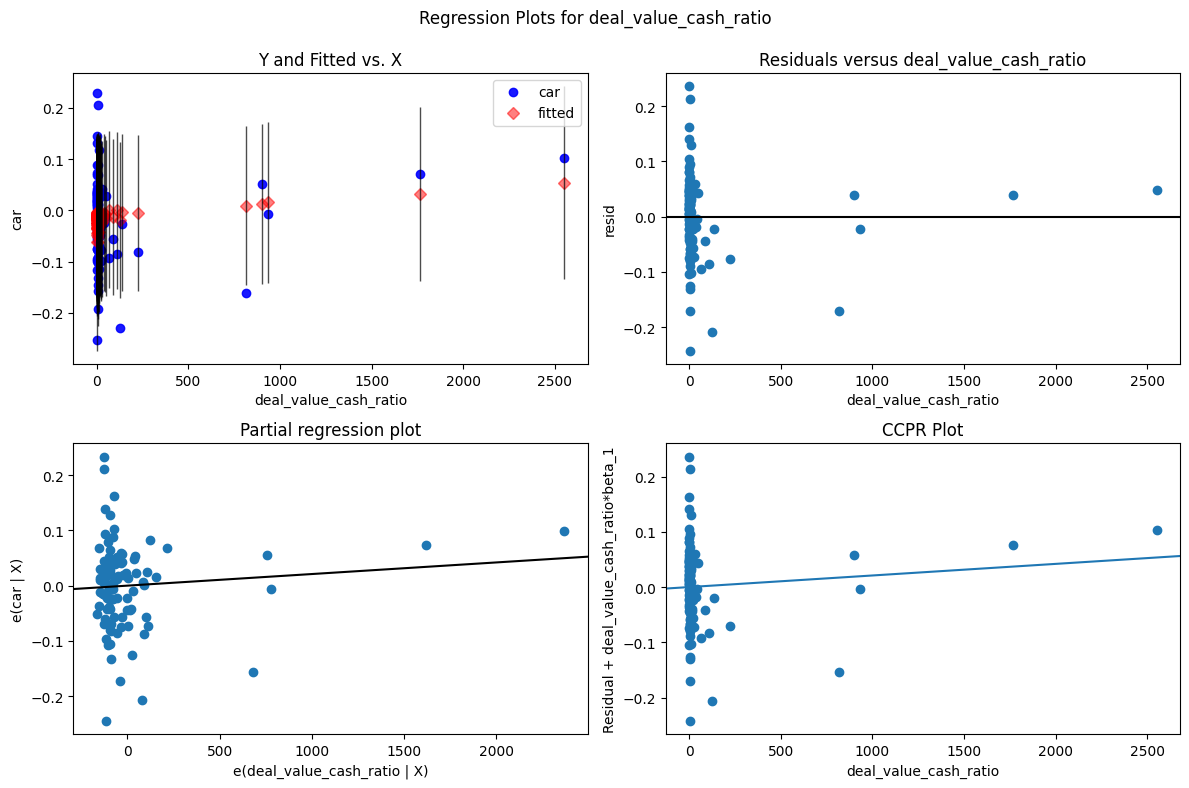

In [22]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model, 'deal_value_cash_ratio', fig=fig)

eval_env: 1


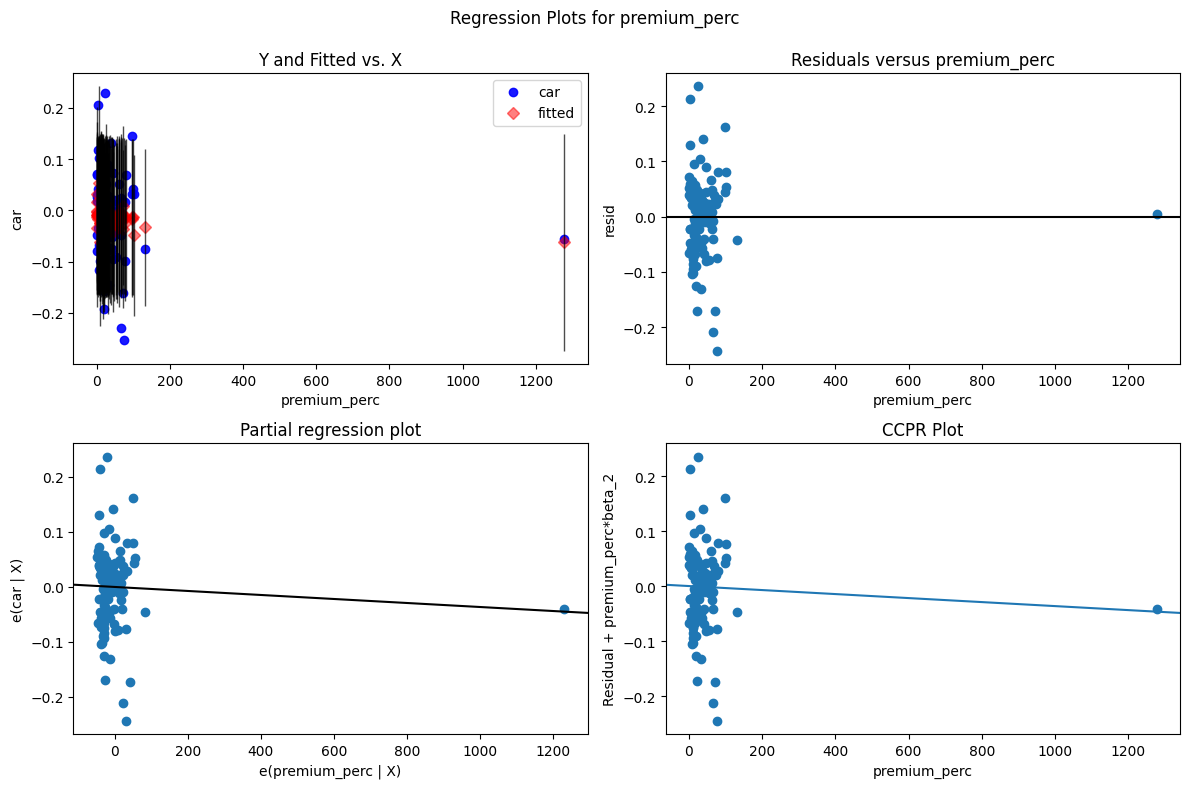

In [23]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model, 'premium_perc', fig=fig)

eval_env: 1


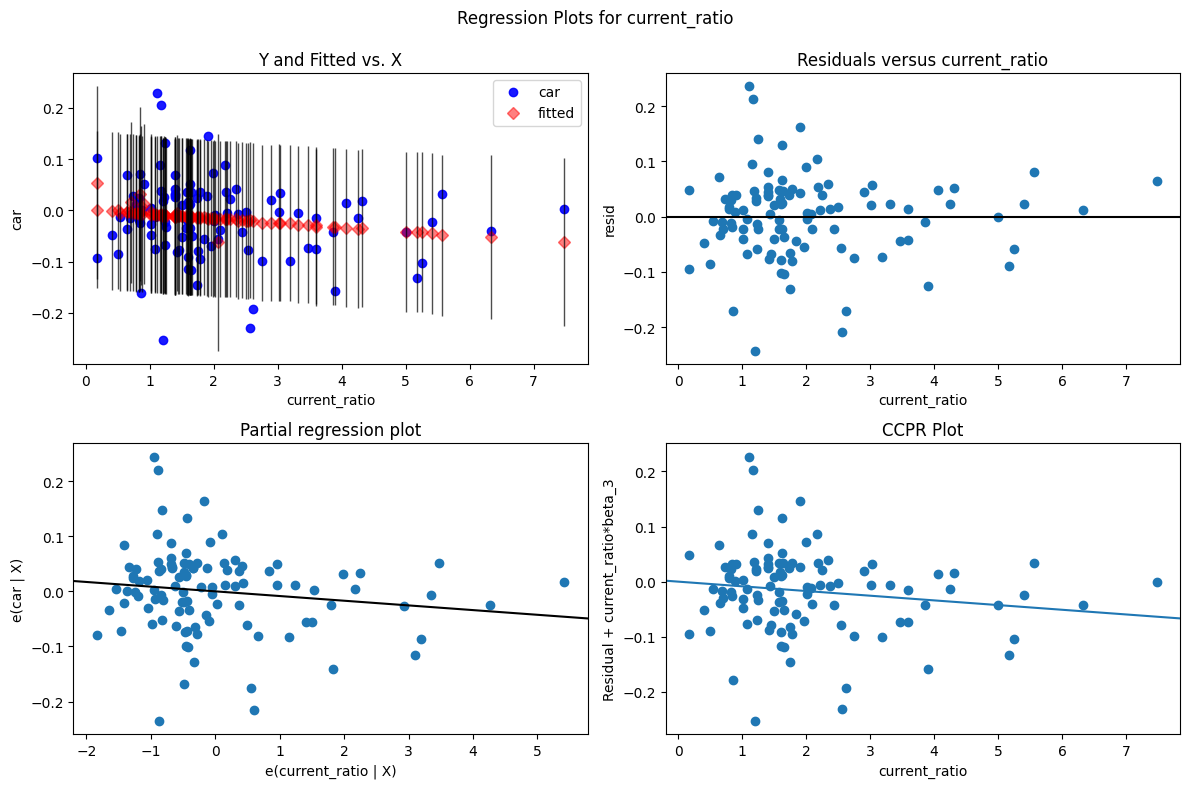

In [24]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model, 'current_ratio', fig=fig)